# Experiment design trade-offs in B2C: MDE, sample size and test duration

This notebook shows how to use the `tecore.design` helpers to:

- design experiments for conversion rate (CR) and ARPU-like metrics;
- understand the trade-off between MDE and required sample size;
- estimate how long an experiment will run given daily traffic;
- compute the minimal detectable effect (MDE) for a fixed sample size.

We use simple B2C scenarios with realistic numbers.

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["figure.figsize"] = (7, 4)

from tecore.design import (
    design_proportion_experiment,
    design_mean_experiment,
    mde_proportions_from_n,
    mde_means_from_n,
)

## 1. Designing a conversion rate experiment

Imagine a B2C product with:

- baseline conversion rate **CR = 5%**;
- daily traffic of **20 000 users** that can be split between A/B;
- we want to detect an improvement of **+1 percentage point** (from 5% to 6%);
- significance level α = 0.05 (two-sided);
- power = 0.80.

We will:

1. Compute the required sample size per group.
2. Translate it into the expected duration of the experiment in days.
3. See how the duration changes when we change the MDE.

In [6]:
# Baseline conversion rate and daily traffic
p_baseline = 0.05
daily_users = 20_000  # total, for both groups

alpha = 0.05
target_power = 0.80
mde_cr = 0.01  # +1 percentage point

design_cr = design_proportion_experiment(
    p_baseline=p_baseline,
    mde=mde_cr,
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

# Daily users per group (equal split)
daily_per_group = daily_users / 2.0

# Estimated duration in days
days_needed = math.ceil(design_cr.n_per_group / daily_per_group)

print("Conversion rate experiment design")
print(f"Baseline CR: {p_baseline:.3%}")
print(f"MDE (absolute): {mde_cr:.3%}")
print(f"Alpha: {alpha:.2f}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Required n per group: {design_cr.n_per_group}")
print(f"Total sample size: {design_cr.n_total}")
print(f"Daily users (total): {daily_users}")
print(f"Daily per group: {daily_per_group:.0f}")
print(f"Estimated duration: {days_needed} days")

Conversion rate experiment design
Baseline CR: 5.000%
MDE (absolute): 1.000%
Alpha: 0.05
Target power: 0.80

Required n per group: 8159
Total sample size: 16318
Daily users (total): 20000
Daily per group: 10000
Estimated duration: 1 days


MDE vs required n_per_group and duration (CR)
MDE = 0.500% -> n_per_group =  31235, duration ≈  4 days
MDE = 1.000% -> n_per_group =   8159, duration ≈  1 days
MDE = 1.500% -> n_per_group =   3781, duration ≈  1 days
MDE = 2.000% -> n_per_group =   2214, duration ≈  1 days


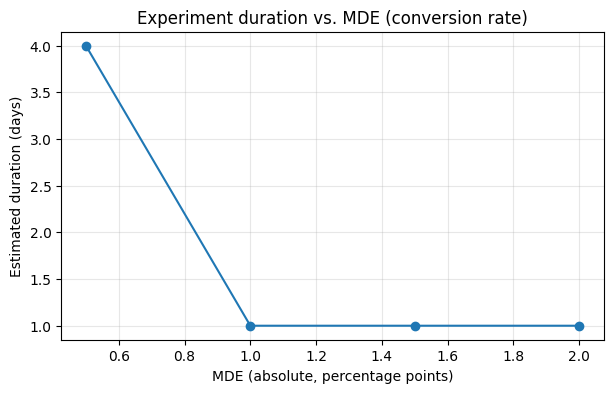

In [7]:
# Different MDE values (absolute difference in CR)
mde_grid = np.array([0.005, 0.01, 0.015, 0.02])  # 0.5pp, 1pp, 1.5pp, 2pp

durations = []
sample_sizes = []

for mde_val in mde_grid:
    d = design_proportion_experiment(
        p_baseline=p_baseline,
        mde=mde_val,
        alpha=alpha,
        power=target_power,
        tail="two-sided",
    )
    sample_sizes.append(d.n_per_group)
    days = math.ceil(d.n_per_group / daily_per_group)
    durations.append(days)

sample_sizes = np.array(sample_sizes)
durations = np.array(durations)

print("MDE vs required n_per_group and duration (CR)")
for mde_val, n, days in zip(mde_grid, sample_sizes, durations):
    print(
        f"MDE = {mde_val:.3%} -> n_per_group = {n:6d}, "
        f"duration ≈ {days:2d} days"
    )

plt.figure()
plt.plot(mde_grid * 100, durations, marker="o")
plt.title("Experiment duration vs. MDE (conversion rate)")
plt.xlabel("MDE (absolute, percentage points)")
plt.ylabel("Estimated duration (days)")
plt.grid(True, alpha=0.3)
plt.show()

### Interpretation

- Smaller MDE (e.g. +0.5 pp) requires **much larger sample size** and a longer test.
- Larger MDE (e.g. +1.5–2 pp) can be detected faster, but:
  - small yet meaningful effects might be missed;
  - business may not care about very large effects if they are unrealistic.

In practice, teams should:

- choose an MDE that is both **business-relevant** and **feasible** given traffic;
- avoid running underpowered tests “just in case”.

## 2. What can we detect with our current traffic?

Now suppose we are constrained:

- we can run an experiment for **10 days**;
- daily traffic is still 20 000 users.

We want to know:

> *What minimal uplift in CR (absolute MDE) can we reasonably detect with 80% power?*

In [8]:
days_planned = 10
n_per_group_fixed = int(daily_per_group * days_planned)

mde_detectable = mde_proportions_from_n(
    p_baseline=p_baseline,
    n_per_group=n_per_group_fixed,
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

print("Detectable MDE for fixed duration (CR)")
print(f"Planned duration: {days_planned} days")
print(f"n_per_group (fixed): {n_per_group_fixed}")
print(f"Baseline CR: {p_baseline:.3%}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Approx. detectable MDE: {mde_detectable:.3%}")
print(f"Relative uplift: {(mde_detectable / p_baseline) * 100:.1f}%")

Detectable MDE for fixed duration (CR)
Planned duration: 10 days
n_per_group (fixed): 100000
Baseline CR: 5.000%
Target power: 0.80

Approx. detectable MDE: 0.279%
Relative uplift: 5.6%


## 3. Designing an ARPU experiment

Now consider a revenue-related metric, e.g. **ARPU (average revenue per user)**.

Assume:

- baseline ARPU ≈ 3.0 units;
- estimated standard deviation `std ≈ 5.0`;
- we want to detect an **increase of 0.3 units**;
- same α = 0.05 and power = 0.80;
- daily traffic = 20 000 users.

We will design the experiment and estimate its duration.

In [9]:
std_arpu = 5.0
mde_arpu = 0.3  # absolute change in ARPU

design_arpu = design_mean_experiment(
    std=std_arpu,
    mde=mde_arpu,
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

days_needed_arpu = math.ceil(design_arpu.n_per_group / daily_per_group)

print("ARPU experiment design")
print(f"Std(ARPU): {std_arpu:.2f}")
print(f"MDE (absolute): {mde_arpu:.2f}")
print(f"Alpha: {alpha:.2f}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Required n per group: {design_arpu.n_per_group}")
print(f"Total sample size: {design_arpu.n_total}")
print(f"Daily users (total): {daily_users}")
print(f"Daily per group: {daily_per_group:.0f}")
print(f"Estimated duration: {days_needed_arpu} days")

ARPU experiment design
Std(ARPU): 5.00
MDE (absolute): 0.30
Alpha: 0.05
Target power: 0.80

Required n per group: 4361
Total sample size: 8722
Daily users (total): 20000
Daily per group: 10000
Estimated duration: 1 days


In [10]:
mde_arpu_detectable = mde_means_from_n(
    std=std_arpu,
    n_per_group=n_per_group_fixed, 
    alpha=alpha,
    power=target_power,
    tail="two-sided",
)

print("Detectable MDE for fixed duration (ARPU)")
print(f"Planned duration: {days_planned} days")
print(f"n_per_group (fixed): {n_per_group_fixed}")
print(f"Std(ARPU): {std_arpu:.2f}")
print(f"Target power: {target_power:.2f}")
print()
print(f"Approx. detectable MDE: {mde_arpu_detectable:.3f} in ARPU units")

Detectable MDE for fixed duration (ARPU)
Planned duration: 10 days
n_per_group (fixed): 100000
Std(ARPU): 5.00
Target power: 0.80

Approx. detectable MDE: 0.063 in ARPU units


## 4. Takeaways

This notebook illustrated how to use high-level design helpers to answer
practical questions:

- *How big should our experiment be to detect a given effect?*
- *How long will it run given our daily traffic?*
- *With our current traffic and time constraints, what MDE is realistic?*

Key points:

- There is always a trade-off between **MDE, sample size and duration**.
- Underpowered tests lead to inconclusive results and wasted effort.
- Designing experiments explicitly (instead of “just launching a test”)
  helps align expectations between product, analytics and marketing teams.

In real B2C work, these calculations can be automated and embedded into
internal tooling so that analysts and product managers can quickly
evaluate whether a proposed experiment is realistic and worth running.